In [3]:
import math
from collections import Counter
import csv
import statistics

class Node:
    def __init__(self, attribute=None, threshold=None, label=None, branches=None):
        self.attribute = attribute
        self.threshold = threshold
        self.label = label
        self.branches = branches or {}

def id3(data, attributes, label_index, max_depth, criterion='info_gain'):
    labels = [row[label_index] for row in data]
    
    if not labels:
        return Node(label=None)
    
    if len(set(labels)) == 1:
        return Node(label=labels[0])
    if len(attributes) == 0 or max_depth == 0:
        return Node(label=max(set(labels), key=labels.count))
    
    best_attribute, threshold = choose_best_attribute(data, attributes, label_index, criterion)
    node = Node(attribute=best_attribute, threshold=threshold)
    
    if threshold is not None:
        left_subset = [row for row in data if row[best_attribute] <= threshold]
        right_subset = [row for row in data if row[best_attribute] > threshold]
        if left_subset:
            node.branches[f"<={threshold}"] = id3(left_subset, attributes, label_index, max_depth - 1, criterion)
        if right_subset:
            node.branches[f">{threshold}"] = id3(right_subset, attributes, label_index, max_depth - 1, criterion)
    else:
        for value in set(row[best_attribute] for row in data if row[best_attribute] != 'unknown'):
            subset = [row for row in data if row[best_attribute] == value]
            if subset:
                node.branches[value] = id3(subset, attributes, label_index, max_depth - 1, criterion)
    
    if not node.branches:
        return Node(label=max(set(labels), key=labels.count))
    
    return node

def choose_best_attribute(data, attributes, label_index, criterion):
    best_gain = -float('inf')
    best_attribute = None
    best_threshold = None
    
    for attribute in attributes:
        if all(isinstance(row[attribute], (int, float)) for row in data if row[attribute] != 'unknown'):
            values = [row[attribute] for row in data if row[attribute] != 'unknown']
            threshold = statistics.median(values)
            gain = calculate_gain(data, attribute, label_index, criterion, threshold)
        else:
            gain = calculate_gain(data, attribute, label_index, criterion)
            threshold = None
        
        if gain > best_gain:
            best_gain = gain
            best_attribute = attribute
            best_threshold = threshold
    
    return best_attribute, best_threshold

def calculate_gain(data, attribute, label_index, criterion, threshold=None):
    if criterion == 'info_gain':
        return information_gain(data, attribute, label_index, threshold)
    elif criterion == 'majority_error':
        return majority_error(data, attribute, label_index, threshold)
    elif criterion == 'gini_index':
        return gini_index(data, attribute, label_index, threshold)
    else:
        raise ValueError("Invalid criterion. Choose 'info_gain', 'majority_error', or 'gini_index'.")

def entropy(data, label_index):
    labels = [row[label_index] for row in data]
    counts = Counter(labels)
    total = len(labels)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def information_gain(data, attribute, label_index, threshold=None):
    total_entropy = entropy(data, label_index)
    weighted_entropy = 0
    
    if threshold is not None:
        left_subset = [row for row in data if row[attribute] <= threshold]
        right_subset = [row for row in data if row[attribute] > threshold]
        weighted_entropy = (len(left_subset) / len(data)) * entropy(left_subset, label_index) + \
                           (len(right_subset) / len(data)) * entropy(right_subset, label_index)
    else:
        for value in set(row[attribute] for row in data):
            subset = [row for row in data if row[attribute] == value]
            weight = len(subset) / len(data)
            weighted_entropy += weight * entropy(subset, label_index)
    
    return total_entropy - weighted_entropy

def majority_error(data, attribute, label_index, threshold=None):
    total_error = 1 - max(Counter(row[label_index] for row in data).values()) / len(data)
    weighted_error = 0
    
    if threshold is not None:
        # Binary split for numerical attributes
        left_subset = [row for row in data if row[attribute] <= threshold]
        right_subset = [row for row in data if row[attribute] > threshold]
        left_error = 1 - max(Counter(row[label_index] for row in left_subset).values()) / len(left_subset) if left_subset else 0
        right_error = 1 - max(Counter(row[label_index] for row in right_subset).values()) / len(right_subset) if right_subset else 0
        weighted_error = (len(left_subset) / len(data)) * left_error + (len(right_subset) / len(data)) * right_error
    else:
        # Categorical split
        for value in set(row[attribute] for row in data):
            subset = [row for row in data if row[attribute] == value]
            weight = len(subset) / len(data)
            majority_class = max(set(row[label_index] for row in subset), key=lambda c: sum(1 for row in subset if row[label_index] == c))
            error = sum(1 for row in subset if row[label_index] != majority_class) / len(subset)
            weighted_error += weight * error
    
    return total_error - weighted_error

def gini_index(data, attribute, label_index, threshold=None):
    def calculate_gini(subset):
        counts = Counter(row[label_index] for row in subset)
        total = len(subset)
        return 1 - sum((count / total) ** 2 for count in counts.values())

    total_gini = calculate_gini(data)
    weighted_gini = 0
    
    if threshold is not None:
        left_subset = [row for row in data if row[attribute] <= threshold]
        right_subset = [row for row in data if row[attribute] > threshold]
        weighted_gini = (len(left_subset) / len(data)) * calculate_gini(left_subset) + \
                        (len(right_subset) / len(data)) * calculate_gini(right_subset)
    else:
        for value in set(row[attribute] for row in data):
            subset = [row for row in data if row[attribute] == value]
            weight = len(subset) / len(data)
            weighted_gini += weight * calculate_gini(subset)
    
    return total_gini - weighted_gini

def predict(node, instance):
    if node.label is not None:
        return node.label
    if node.attribute >= len(instance):
        return None
    value = instance[node.attribute]
    if node.threshold is not None:
        if value == 'unknown':
            return None
        if value <= node.threshold:
            branch = f"<={node.threshold}"
        else:
            branch = f">{node.threshold}"
    else:
        branch = value
    if branch not in node.branches:
        return None
    return predict(node.branches[branch], instance)

def load_data(filename):
    data = []
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            instance = []
            for value in row:
                try:
                    instance.append(float(value))
                except ValueError:
                    instance.append(value)
            data.append(instance)
    return data

def replace_unknown(train_data, test_data):
    for attr in range(len(train_data[0]) - 1): 
        values = [row[attr] for row in train_data if row[attr] != 'unknown']
        if values:
            majority = max(set(values), key=values.count)
            for row in train_data:
                if row[attr] == 'unknown':
                    row[attr] = majority
            for row in test_data:
                if row[attr] == 'unknown':
                    row[attr] = majority
    return train_data, test_data

def calculate_error(tree, data, label_index):
    incorrect = sum(1 for instance in data if predict(tree, instance) != instance[label_index])
    return incorrect / len(data)

def run_experiment(train_data, test_data, max_depths, criteria):
    num_attributes = len(train_data[0]) - 1
    attributes = list(range(num_attributes))
    label_index = -1
    
    results = {criterion: {depth: {'train': 0, 'test': 0} for depth in max_depths} for criterion in criteria}
    
    for criterion in criteria:
        for depth in max_depths:
            tree = id3(train_data, attributes, label_index, depth, criterion)
            train_error = calculate_error(tree, train_data, label_index)
            test_error = calculate_error(tree, test_data, label_index)
            results[criterion][depth]['train'] = train_error
            results[criterion][depth]['test'] = test_error
    
    return results

In [4]:
train_data = load_data('train_bank.csv')
test_data = load_data('test_bank.csv')
train_data, test_data = replace_unknown(train_data, test_data)

max_depths = range(1, 17)
criteria = ['info_gain', 'majority_error', 'gini_index']
results = run_experiment(train_data, test_data, max_depths, criteria)

print("Depth | Information Gain | Majority Error | Gini Index")
print("      | Train  | Test    | Train  | Test   | Train | Test")
print("------|--------|---------|--------|--------|-------|------")
for depth in max_depths:
    print(f"{depth:5d} | {results['info_gain'][depth]['train']:.4f} | {results['info_gain'][depth]['test']:.4f} | "
          f"{results['majority_error'][depth]['train']:.4f} | {results['majority_error'][depth]['test']:.4f} | "
          f"{results['gini_index'][depth]['train']:.4f} | {results['gini_index'][depth]['test']:.4f}")

Depth | Information Gain | Majority Error | Gini Index
      | Train  | Test    | Train  | Test   | Train | Test
------|--------|---------|--------|--------|-------|------
    1 | 0.1192 | 0.1248 | 0.1088 | 0.1166 | 0.1088 | 0.1166
    2 | 0.1060 | 0.1114 | 0.1074 | 0.1148 | 0.1080 | 0.1156
    3 | 0.1042 | 0.1156 | 0.1002 | 0.1154 | 0.1002 | 0.1242
    4 | 0.0934 | 0.1298 | 0.0910 | 0.1234 | 0.0932 | 0.1286
    5 | 0.0796 | 0.1290 | 0.0796 | 0.1340 | 0.0828 | 0.1302
    6 | 0.0650 | 0.1372 | 0.0682 | 0.1428 | 0.0682 | 0.1414
    7 | 0.0418 | 0.1532 | 0.0616 | 0.1468 | 0.0436 | 0.1540
    8 | 0.0218 | 0.1632 | 0.0546 | 0.1550 | 0.0244 | 0.1652
    9 | 0.0102 | 0.1698 | 0.0502 | 0.1602 | 0.0114 | 0.1698
   10 | 0.0040 | 0.1678 | 0.0470 | 0.1614 | 0.0042 | 0.1686
   11 | 0.0010 | 0.1684 | 0.0460 | 0.1620 | 0.0010 | 0.1694
   12 | 0.0008 | 0.1682 | 0.0452 | 0.1636 | 0.0002 | 0.1694
   13 | 0.0000 | 0.1682 | 0.0452 | 0.1636 | 0.0000 | 0.1694
   14 | 0.0000 | 0.1682 | 0.0452 | 0.1636 | 0.00

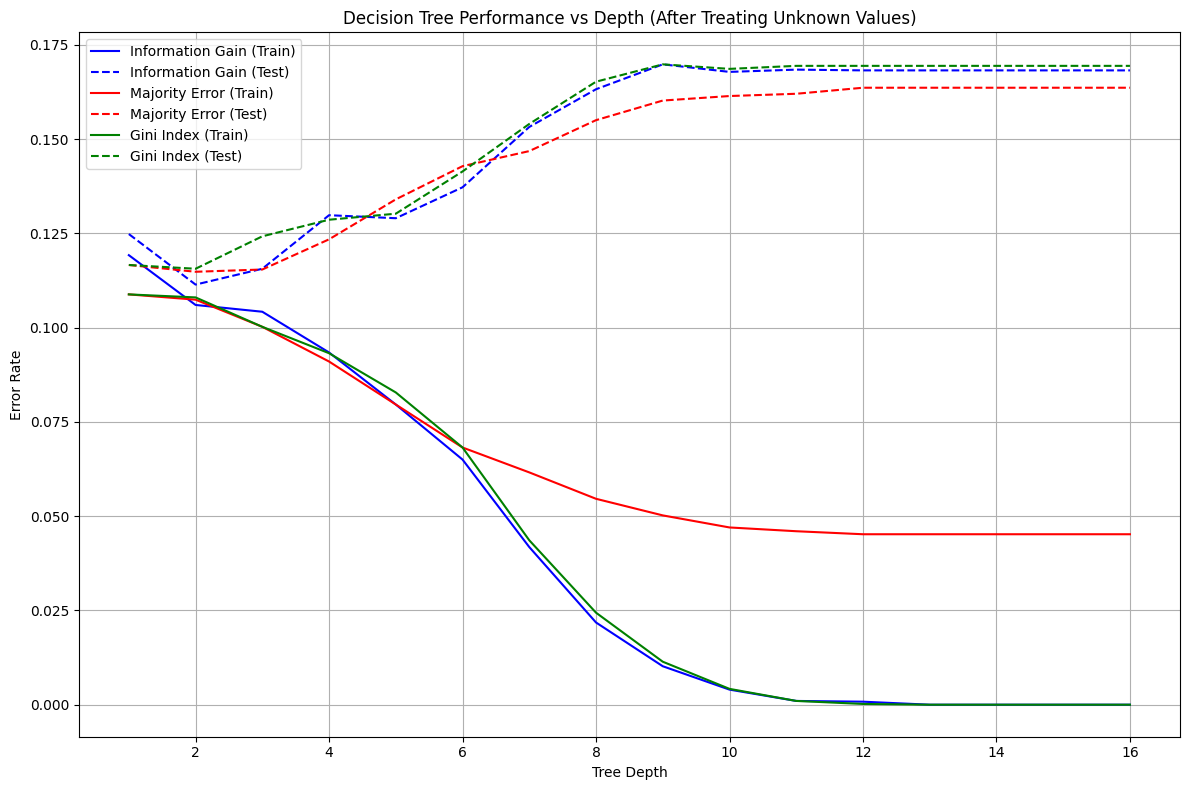

In [6]:
import matplotlib.pyplot as plt

# Data from the table
depths = list(range(1, 17))
info_gain_train = [0.1192, 0.1060, 0.1042, 0.0934, 0.0796, 0.0650, 0.0418, 0.0218, 0.0102, 0.0040, 0.0010, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000]
info_gain_test = [0.1248, 0.1114, 0.1156, 0.1298, 0.1290, 0.1372, 0.1532, 0.1632, 0.1698, 0.1678, 0.1684, 0.1682, 0.1682, 0.1682, 0.1682, 0.1682]
majority_error_train = [0.1088, 0.1074, 0.1002, 0.0910, 0.0796, 0.0682, 0.0616, 0.0546, 0.0502, 0.0470, 0.0460, 0.0452, 0.0452, 0.0452, 0.0452, 0.0452]
majority_error_test = [0.1166, 0.1148, 0.1154, 0.1234, 0.1340, 0.1428, 0.1468, 0.1550, 0.1602, 0.1614, 0.1620, 0.1636, 0.1636, 0.1636, 0.1636, 0.1636]
gini_index_train = [0.1088, 0.1080, 0.1002, 0.0932, 0.0828, 0.0682, 0.0436, 0.0244, 0.0114, 0.0042, 0.0010, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000]
gini_index_test = [0.1166, 0.1156, 0.1242, 0.1286, 0.1302, 0.1414, 0.1540, 0.1652, 0.1698, 0.1686, 0.1694, 0.1694, 0.1694, 0.1694, 0.1694, 0.1694]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot lines for each method
plt.plot(depths, info_gain_train, 'b-', label='Information Gain (Train)')
plt.plot(depths, info_gain_test, 'b--', label='Information Gain (Test)')
plt.plot(depths, majority_error_train, 'r-', label='Majority Error (Train)')
plt.plot(depths, majority_error_test, 'r--', label='Majority Error (Test)')
plt.plot(depths, gini_index_train, 'g-', label='Gini Index (Train)')
plt.plot(depths, gini_index_test, 'g--', label='Gini Index (Test)')

# Customize the plot
plt.title('Decision Tree Performance vs Depth (After Treating Unknown Values)')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()